# CNN-BiLSTM

This notebook is based on the work of "End-to-end Sequence Labelling via Bidirectional LSTM-CNNs-CRF https://arxiv.org/pdf/1603.01354.pdf

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, concatenate, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Conv1D, SpatialDropout1D,GlobalMaxPooling1D, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

from keras_contrib.layers import CRF

In [62]:
def load_data(file_path):
    file = open(file_path, "r")
    data, entities, sentence, unique_labels = [], [], [], []
    for line in file:
        line = line.strip("\n").split("\t")
        
        if len(line) > 1:
            word = line[0]
            label = line[1]
            
            sentence.append(word)
            entities.append(label)
            
            if label not in unique_labels:
                unique_labels.append(label)
            
        elif len(entities) > 0:
            sentence = " ".join(sentence)
            data.append({"sentence" : sentence, "entities" : entities})
            entities, sentence = [], []
            
    file.close()
    return data, unique_labels

In [83]:
train_dev_filepath = "NERdata/NCBI-disease/train_dev.tsv"
test_filepath = "NERdata/NCBI-disease/test.tsv"

train_data, train_unq_labels = load_data(train_dev_filepath)
test_data, _ = load_data(test_filepath)

data = train_data + test_data

In [84]:
data[0]

{'sentence': 'Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .',
 'entities': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'I',
  'O',
  'O']}

In [85]:
#Check how many datapoints and unique labels we have acquired from the dataset

len(data), len(unq_labels)

(7287, 3)

In [86]:
#Now we will make reference dictionaries for the text elements

def get_mappings(data, word_ent):

    if word_ent == "word" or word_ent == "char":
        vocab = Counter([i for x in data for i in x['sentence'].split()])
        if word_ent == "char":
            vocab = Counter([i for x in vocab for i in list(x)])
    elif word_ent == "ent":
        vocab = Counter([i for x in data for i in x['entities']])
    
    vocab = [i[0] for i in vocab.most_common()]
    
    idx2tok = {idx:tok for idx, tok in enumerate(vocab, 1)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab, 1)}
    
    return tok2idx, idx2tok


word2idx, idx2word = get_mappings(data, "word")
char2idx, idx2char = get_mappings(data, "char")
tag2idx, idx2tag = get_mappings(data, "ent")

n_words = len(word2idx)
n_chars = len(char2idx)

In [87]:
# We will add a PAD token to consider padding during training

word2idx["UNK"] = n_words + 1
idx2word[n_words + 1] = "UNK"

word2idx["PAD"] = 0
idx2word[0] = "PAD"

char2idx["UNK"] = n_chars + 1
idx2char[n_chars + 1] = "UNK"

char2idx["PAD"] = 0
idx2char[0] = "PAD"

tag2idx["PAD"] = 0
idx2tag[0] = "PAD"


assert len(word2idx) == len(idx2word) and len(char2idx) == len(idx2char)

In [88]:
tag2idx

{'O': 1, 'I': 2, 'B': 3, 'PAD': 0}

In [89]:
n_words = len(word2idx)
n_chars = len(char2idx)

print("There are {} unique words/elements in the corpus being considered".format(n_words))

There are 10820 unique words/elements in the corpus being considered


For convenience let us create a Pandas df summarising all the relevant data to this point

In [90]:
columns = ["Sentence", "Labels", "Word Tokens", "Label Tokens", "Character Tokens"]

data_df = []
for i in range(len(data)):
    #We want data in the form : [Sentence, Labels, Words Tokens, Label Tokens]
    sentence = data[i]['sentence']
    labels = data[i]['entities']
    words = sentence.split()
    chars = [list(i) for i in words]
    word_tkns = [word2idx.get(i) for i in words]
    label_tkns = [tag2idx.get(i) for i in labels]
    char_tkns = [list(map(char2idx.get, i)) for i in chars]
    
    data_df.append([sentence, labels, word_tkns, label_tkns, char_tkns])
    
data_df = pd.DataFrame(data_df, columns = columns)

In [91]:
data_df.head()

,Sentence,Labels,Word Tokens,Label Tokens,Character Tokens
0,"Identification of APC2 , a homologue of the ad...","[O, O, O, O, O, O, O, O, B, I, I, I, O, O]","[777, 3, 2888, 4, 8, 778, 3, 2, 335, 280, 532,...","[1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1]","[[37, 11, 1, 4, 6, 2, 20, 2, 10, 3, 6, 2, 5, 4..."
1,The adenomatous polyposis coli ( APC ) tumour ...,"[O, B, I, I, I, I, I, I, O, O, O, O, O, O, O, ...","[18, 335, 280, 532, 10, 115, 9, 507, 6, 355, 3...","[1, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...","[[34, 17, 1], [3, 11, 1, 4, 5, 13, 3, 6, 5, 14..."
2,Complex formation induces the rapid degradatio...,"[O, O, O, O, O, O, O, O, O]","[4814, 623, 3363, 2, 1036, 2889, 3, 3362, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[[24, 5, 13, 12, 9, 1, 32], [20, 5, 7, 13, 3, ..."
3,"In colon carcinoma cells , loss of APC leads t...","[O, B, I, O, O, O, O, O, O, O, O, O, O, O, O, ...","[51, 1577, 578, 84, 4, 160, 3, 115, 872, 11, 2...","[1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[37, 4], [10, 5, 9, 5, 4], [10, 3, 7, 10, 2, ..."
4,"Here , we report the identification and genomi...","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[368, 4, 54, 149, 2, 397, 7, 197, 517, 3, 115,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[43, 1, 7, 1], [63], [44, 1], [7, 1, 12, 5, 7..."


<BarContainer object of 3 artists>

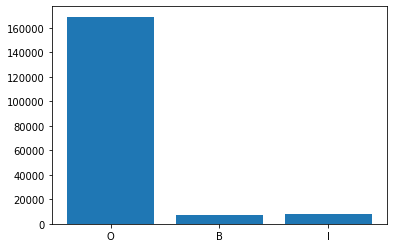

In [92]:
from collections import Counter

labels = [i for x in data_df["Labels"].values for i in x]
cnt = Counter(labels)
plt.bar(cnt.keys(), cnt.values())

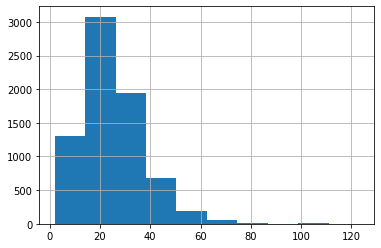

count    7287.000000
mean       25.273364
std        12.583760
min         2.000000
25%        17.000000
50%        23.000000
75%        32.000000
max       123.000000
Name: Word Tokens, dtype: float64

In [93]:
lengths = data_df['Word Tokens'].map(len)

lengths.hist()
plt.show()

lengths.describe()

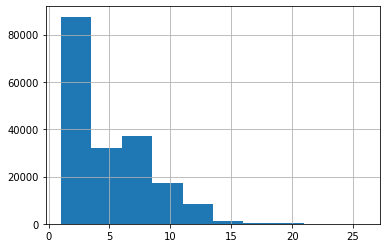

count    184167.000000
mean          4.682104
std           3.334064
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          26.000000
dtype: float64

In [94]:
words = data_df["Character Tokens"]
word_lengths = pd.Series([len(x) for i in words for x in i])

word_lengths.hist()
plt.show()

word_lengths.describe()

In [95]:
MAX_CHAR = 26
MAX_WORD = 123

padded_sentences = pad_sequences(data_df["Word Tokens"], maxlen=MAX_WORD, dtype='int32', padding='post', truncating='post', value= word2idx["PAD"])
padded_labels = pad_sequences(data_df["Label Tokens"], maxlen = MAX_WORD, dtype='int32', padding='post', truncating='post', value= tag2idx["PAD"])
padded_labels = np.array([to_categorical(i, num_classes = len(tag2idx)) for i in padded_labels])
padded_chars = [pad_sequences(x, maxlen = MAX_CHAR, dtype = 'int32', padding = 'post', truncating = 'post', value= char2idx["PAD"]) for x in data_df["Character Tokens"]]
padded_chars = pad_sequences(padded_chars, maxlen = MAX_WORD, padding = 'post', value = [0]*MAX_CHAR)

no_samples = np.shape(padded_sentences)[0]

In [96]:
idx = list(range(no_samples))

train_idx, val_test_idx = train_test_split(idx, test_size = 0.6, shuffle = True, random_state = 2021)
val_idx, test_idx = train_test_split(val_test_idx, test_size = 0.5)

train_sent, train_chars, train_labels = padded_sentences[train_idx], padded_chars[train_idx], padded_labels[train_idx]
val_sent, val_chars, val_labels = padded_sentences[val_idx], padded_chars[val_idx], padded_labels[val_idx]
test_sent, test_chars, test_labels = padded_sentences[test_idx], padded_chars[test_idx], padded_labels[test_idx]

## Build Model

In [97]:
def get_model(word_vocab_size, char_vocab_size, max_word_len, max_char_len, lr = 0.001):
    WORD_EMB_DIM = 64
    CHAR_EMB_DIM = 32

    # Input and Embedding for words
    word_input = Input(shape = (max_word_len,))
    word_emb = Embedding(input_dim=word_vocab_size + 1, output_dim=WORD_EMB_DIM, trainable = True,
                         input_length=max_word_len, mask_zero = True, name = "word_embed")(word_input)
    
    
    
    # Input and Embedding for characters
    char_input= Input(shape = (max_word_len, max_char_len,))
    char_emb = TimeDistributed(Embedding(input_dim = char_vocab_size + 1, output_dim = CHAR_EMB_DIM, trainable = True,
                                        input_length = max_char_len, name = "char_embed"))(char_input)
    
    
    # Character CNN feature extraction with filter of length 3
    char_conv = TimeDistributed(Conv1D(32, 3, padding='same'), name = "td_conv1d")(char_emb)
    char_pool = TimeDistributed(GlobalMaxPooling1D(), name="char_pooling")(char_conv)
    
    # Main LSTM
    x = concatenate([word_emb, char_pool])
    x = SpatialDropout1D(0.3)(x)
    main_lstm = Bidirectional(LSTM(units=32, return_sequences=True), name = 'bilstm')(x)
    
    out = TimeDistributed(Dense(len(tag2idx), activation="softmax"), name = 'tdd')(main_lstm)

    model = Model([word_input, char_input], out)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, clipvalue =0.5), metrics=['accuracy'])
    
    model.summary()
    
    return model

In [98]:
model = get_model(len(word2idx), len(char2idx), MAX_WORD, MAX_CHAR, 0.001)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 123, 26)]    0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 123, 26, 32)  2816        input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 123)]        0                                            
__________________________________________________________________________________________________
td_conv1d (TimeDistributed)     (None, 123, 26, 32)  3104        time_distributed_5[0][0]         
____________________________________________________________________________________________

In [99]:
history = model.fit(x = [train_sent, train_chars], y = train_labels, validation_data = ([val_sent, val_chars], val_labels),
                   batch_size = 32, epochs = 10, verbose = 1)

Train on 2914 samples, validate on 2186 samples
Epoch 1/10
2914/2914 [==============================] - 19s 6ms/sample - loss: 0.1023 - accuracy: 0.9060 - val_loss: 0.0641 - val_accuracy: 0.9164
Epoch 2/10
2914/2914 [==============================] - 21s 7ms/sample - loss: 0.0471 - accuracy: 0.9250 - val_loss: 0.0340 - val_accuracy: 0.9388
Epoch 3/10
2914/2914 [==============================] - 19s 6ms/sample - loss: 0.0261 - accuracy: 0.9543 - val_loss: 0.0259 - val_accuracy: 0.9582
Epoch 4/10
2914/2914 [==============================] - 19s 7ms/sample - loss: 0.0186 - accuracy: 0.9701 - val_loss: 0.0218 - val_accuracy: 0.9662
Epoch 5/10
2914/2914 [==============================] - 16s 6ms/sample - loss: 0.0145 - accuracy: 0.9767 - val_loss: 0.0203 - val_accuracy: 0.9687
Epoch 6/10
2914/2914 [==============================] - 16s 6ms/sample - loss: 0.0120 - accuracy: 0.9806 - val_loss: 0.0211 - val_accuracy: 0.9695
Epoch 7/10
2914/2914 [==============================] - 16s 6ms/sample

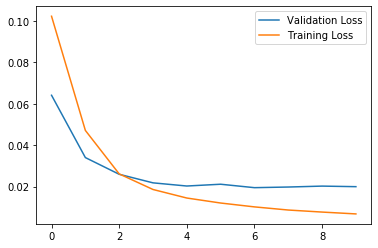

In [105]:
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.plot(history.history['loss'], label = "Training Loss")
plt.legend(loc = "best")

## Evaluation

In [106]:
loss, acc = model.evaluate([test_sent, test_chars], test_labels)

2187/2187 [==============================] - 2s 829us/sample - loss: 0.0185 - accuracy: 0.9754


In [107]:
preds = model.predict([test_sent, test_chars])

In [109]:
print(classification_report([idx2tag[np.argmax(x)] for i in preds for x in i], [idx2tag[np.argmax(i)] for x in test_labels for i in x], labels = ["B", "I"]))

              precision    recall  f1-score   support

           B       0.83      0.83      0.83      2002
           I       0.79      0.63      0.70      3074

   micro avg       0.80      0.71      0.75      5076
   macro avg       0.81      0.73      0.76      5076
weighted avg       0.80      0.71      0.75      5076



In [111]:
i = 234
p = np.argmax(preds[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_sent[i], np.argmax(test_labels[i], axis = -1), p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
To             : O     O
discriminate   : O     O
variants       : O     O
of             : O     O
Pelizaeus      : B     B
-              : I     I
Merzbacher     : I     I
disease        : I     I
,              : O     O
a              : O     O
set            : O     O
of             : O     O
oligonucleotide: O     O
primers        : O     O
was            : O     O
constructed    : O     O
to             : O     O
polymerase     : O     O
-              : O     O
chain          : O     O
-              : O     O
reaction       : O     O
(              : O     O
PCR            : O     O
)              : O     O
amplify        : O     O
and            : O     O
sequence       : O     O
the            : O     O
gene           : O     O
encoding       : O     O
proteolipid    : O     O
protein        : O     O
(              : O     O
PLP            : O     O
)              : O     O
,              : O     O
a              : O     O
structural     : O   